In [17]:
import os
from pathlib import Path, PosixPath
import pandas as pd
from pprint import pprint

def parse_log(log):
    hparams = eval(log[0])
    data = {}
    data['name'], data['dataset'], data['seed'] = hparams['method_name'], hparams['dataset_name'], hparams['seeds']
    test_scores = [l for l in log if 'Test' in l]
    for line in test_scores:
        line = line.strip()
        if ':' in line:
            key, value = line.split(':', 1)
            key = key.strip()
            value = value.strip()
            if key in ['Test Logscore', 'Test CRPS', 'Test ECE']:
                data[key.split(' ')[1].lower()] = float(value)
    return data
 
runsdir = Path('runs')
table = []
for run in os.listdir(runsdir):
    logfile = runsdir / run / 'log.txt'
    if not logfile.exists():
        continue
    with open(logfile, 'r') as f:
        log = f.readlines()
        table.append(parse_log(log))
table = pd.DataFrame(table)
table



,name,dataset,seed,logscore,crps,ece
0,iqn,concrete,2,0.000502,0.002880,0.188293
1,laplacescore,liver,0,-4.462485,0.001395,0.161560
2,laplacescore,power,0,-2.168075,0.018529,0.032129
3,iqn,power,0,0.000500,0.022744,0.019474
4,ce,abalone,1,-2.297964,0.016238,0.045258
...,...,...,...,...,...,...
122,laplacescore,abalone,0,-2.516402,0.017843,0.058868
123,mdn,abalone,2,-2.939949,0.010312,0.097974
124,laplacewb,energy,2,-4.894962,0.000866,0.194469
125,crpsqr,bishop_toy,1,0.115804,0.111577,0.051359


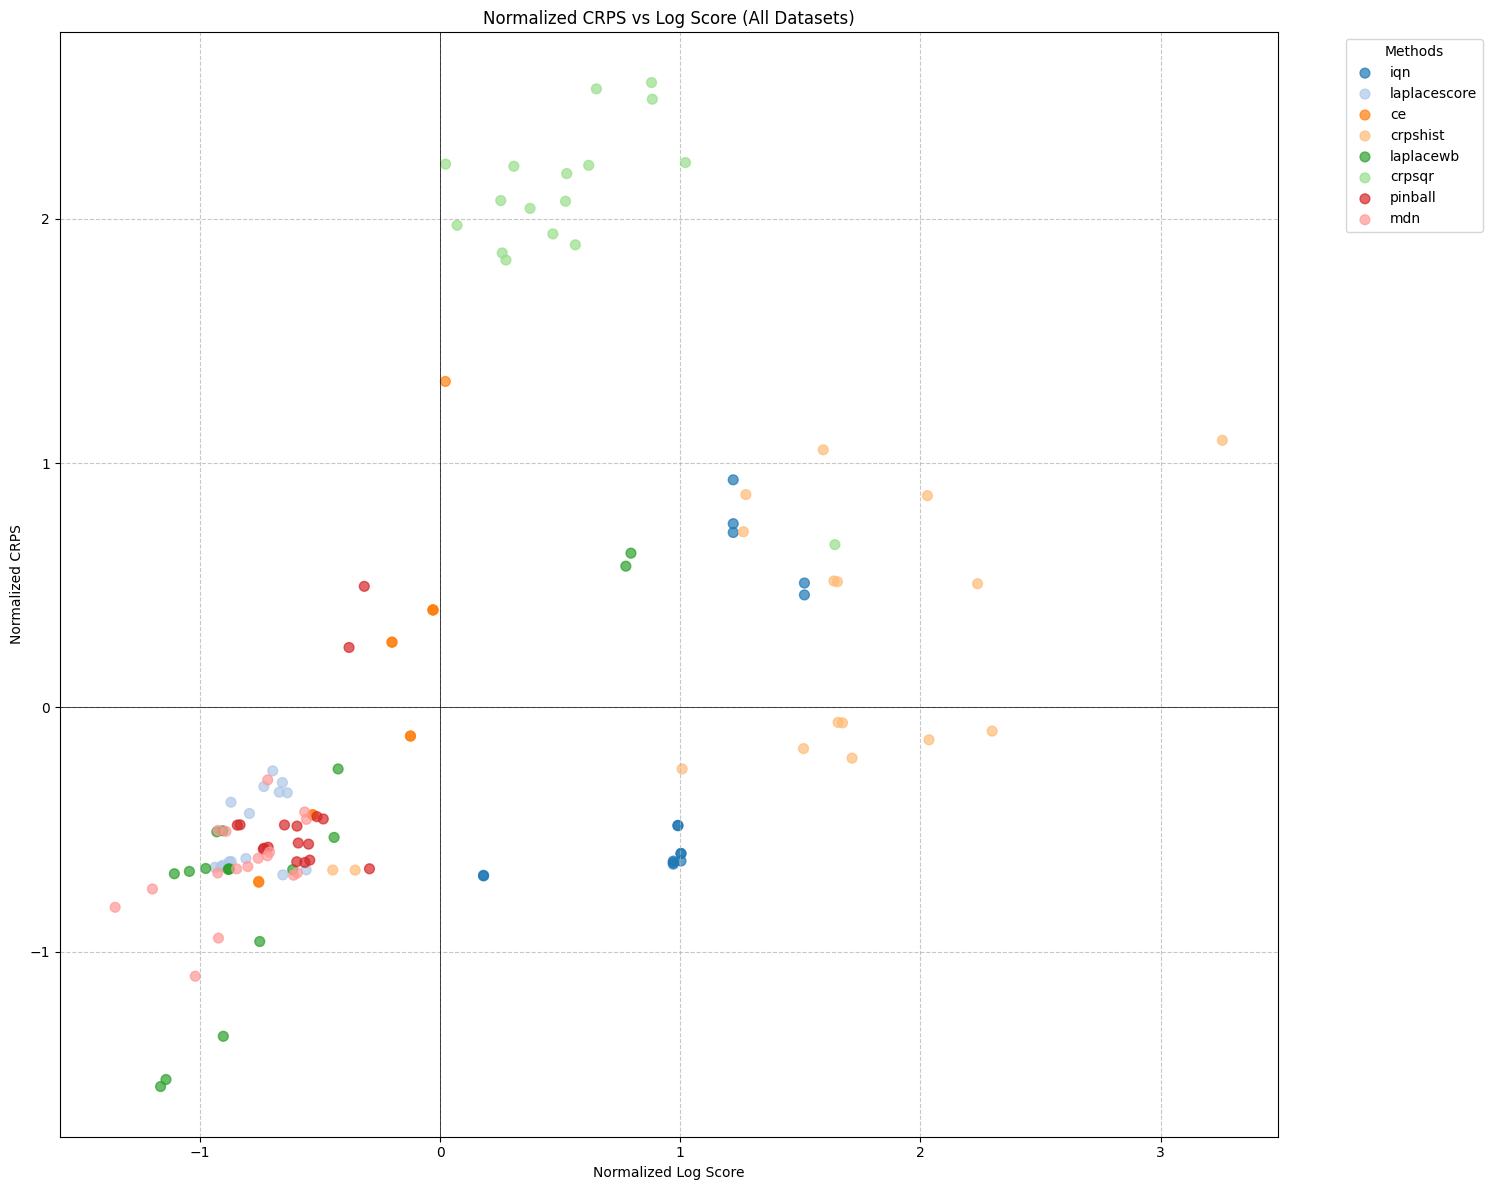

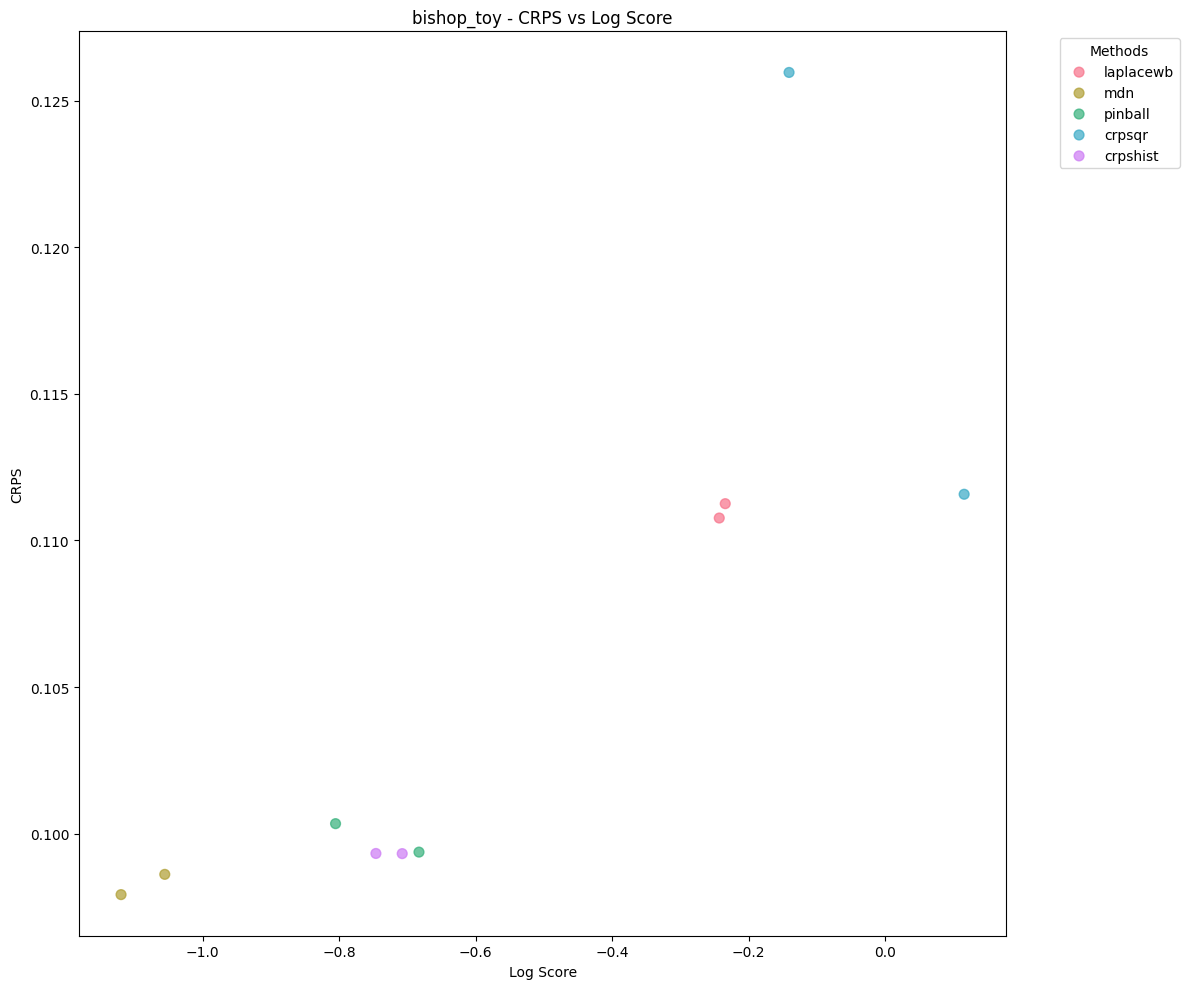

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import ListedColormap


def plot_dataset(dataset_df, dataset_name):
    plt.figure(figsize=(12, 10))
    
    # Get unique methods and assign colors
    methods = dataset_df['name'].unique()
    color_palette = sns.color_palette("husl", n_colors=len(methods))
    color_dict = dict(zip(methods, color_palette))
    
    # Plot each method
    for method in methods:
        method_df = dataset_df[dataset_df['name'] == method]
        plt.scatter(method_df['logscore'], method_df['crps'], 
                    s=50,  # Fixed size for all points
                    c=[color_dict[method]] * len(method_df),
                    alpha=0.7, label=method)
    
    plt.xlabel('Log Score')
    plt.ylabel('CRPS')
    plt.title(f'{dataset_name} - CRPS vs Log Score')
    
    # Add a legend
    plt.legend(title='Methods', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()


def normalize_scores(df):
    for dataset in df['dataset'].unique():
        mask = df['dataset'] == dataset
        for score in ['logscore', 'crps']:
            mean = df.loc[mask, score].mean()
            std = df.loc[mask, score].std()
            df.loc[mask, f'{score}_normalized'] = (df.loc[mask, score] - mean) / std
    return df


def plot_all_datasets(df):
    plt.figure(figsize=(15, 12))
    
    # Get unique methods
    methods = df['name'].unique()
    
    # Create a color palette with distinct colors
    base_colors = plt.cm.tab20(np.linspace(0, 1, 20))
    if len(methods) > 20:
        # If we need more than 20 colors, we'll repeat the palette
        repeats = int(np.ceil(len(methods) / 20))
        colors = np.tile(base_colors, (repeats, 1))[:len(methods)]
    else:
        colors = base_colors[:len(methods)]
    
    color_palette = ListedColormap(colors)
    color_dict = dict(zip(methods, color_palette.colors))
    
    # Plot each method
    for method in methods:
        method_df = df[df['name'] == method]
        plt.scatter(method_df['logscore_normalized'], method_df['crps_normalized'], 
                    s=50,  # Fixed size for all points
                    c=[color_dict[method]] * len(method_df),
                    alpha=0.7, label=method)
    
    plt.xlabel('Normalized Log Score')
    plt.ylabel('Normalized CRPS')
    plt.title('Normalized CRPS vs Log Score (All Datasets)')
    
    # Add a legend
    plt.legend(title='Methods', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Add grid lines
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Add zero lines
    plt.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
    plt.axvline(x=0, color='k', linestyle='-', linewidth=0.5)
    
    plt.tight_layout()
    plt.show()

# Assuming df is your DataFrame
df = normalize_scores(table)
plot_all_datasets(df)

# # Get unique datasets
# datasets = table['dataset'].unique()

# # Plot for each dataset
# for dataset in datasets:
#     dataset_df = table[table['dataset'] == dataset]
plot_dataset(table[table['dataset']=='bishop_toy'], 'bishop_toy')

In [26]:
# pprint(hparams)
table['dataset'].unique()

array(['concrete', 'liver', 'power', 'abalone', 'parkinsons',
       'bishop_toy', 'energy'], dtype=object)